<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [211]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [212]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-08-24 15:39:38--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-08-24 15:39:39 (72.6 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [213]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [214]:
df.shape

(346, 10)

### Convert to date time object


In [215]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [216]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [217]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



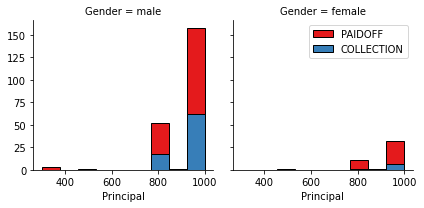

In [218]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

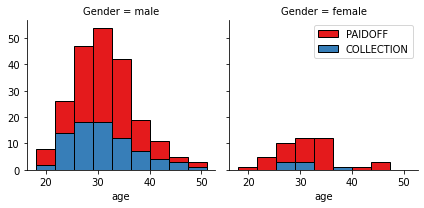

In [219]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


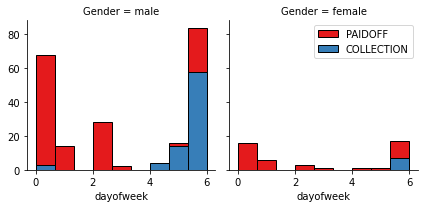

In [220]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [221]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [222]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [223]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [224]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [225]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [226]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [227]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [228]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [229]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [230]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
#k initiator
k = [1,2,3,4,5,6,7,8,9,10]
#splits initiator
spliter = [0.2,0.3,0.4,0.5]
#spliter = [0.1,0.2,0.3,0.4]
test_acc_std = np.zeros((len(spliter),len(k)))
test_acc = np.zeros((len(spliter),len(k)))
best_score = 0
best_k = 1
best_split = 0

#Train Model and Predict  
for s in spliter:
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=s, random_state=4)
    for i in k:
        knn = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
        y_testPredict = knn.predict(X_test)
        # Jaccard Score
        test_acc[int(s*10-2),i-1]=metrics.accuracy_score(y_test, y_testPredict)
        test_acc_std[int(s*10-2),i-1]=np.std(y_testPredict==y_test)/np.sqrt(y_testPredict.shape[0])
        if metrics.accuracy_score(y_test, y_testPredict) > best_score:
            best_score = metrics.accuracy_score(y_test, y_testPredict)
            best_k = i
            best_split = s

            
print('Best score is: ',best_score,'Best k is: ', best_k,'Best split is: ', best_split)   
test_acc

# After testing k=7 is the best for split = 0.1,0.2 and k-=5 for split=0.3,0.4

Best score is:  0.7857142857142857 Best k is:  7 Best split is:  0.2


array([[0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
        0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857],
       [0.71153846, 0.625     , 0.72115385, 0.72115385, 0.73076923,
        0.71153846, 0.72115385, 0.72115385, 0.75      , 0.68269231],
       [0.6618705 , 0.64028777, 0.72661871, 0.69064748, 0.74100719,
        0.73381295, 0.72661871, 0.73381295, 0.71942446, 0.72661871],
       [0.69364162, 0.64739884, 0.68208092, 0.65317919, 0.7283237 ,
        0.71676301, 0.73410405, 0.73410405, 0.71098266, 0.71098266]])

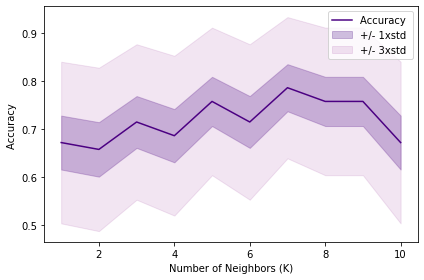

In [231]:
# For split =0.2
t_acc = test_acc[0,:]
t_acc_std = test_acc_std[0,:]

plt.plot(k,t_acc,'indigo')
plt.fill_between(k,t_acc - 1 * t_acc_std,t_acc + 1 * t_acc_std, alpha=0.30,color="rebeccapurple")
plt.fill_between(k,t_acc - 3 * t_acc_std,t_acc + 3 * t_acc_std, alpha=0.10,color="purple")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [232]:
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)
y_testPredict = knn.predict(X_test)
knn_jaccard = best_score
knn_f1 = float(classification_report(y_test, y_testPredict)[311:315])
print('knn_jaccard: ',knn_jaccard,'&  knn_f1: ',knn_f1)

knn_jaccard:  0.7857142857142857 &  knn_f1:  0.78


# Decision Tree


In [233]:
#Fix test% to 0.2
from sklearn.tree import DecisionTreeClassifier
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
Tree.fit(X_train,y_train)
y_testPredict = Tree.predict(X_test)
DecisionT_jaccard = metrics.accuracy_score(y_test, y_testPredict)
DecisionT_f1 = classification_report(y_test, y_testPredict)

In [234]:
print('DecisionT_jaccard: ', DecisionT_jaccard,'&  DecisionT_f1: ',DecisionT_f1[311:315])

DecisionT_jaccard:  0.6142857142857143 &  DecisionT_f1:  0.64


# Support Vector Machine


In [235]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
#y = df['loan_status'].values
#y = np.asarray(df['loan_status'])
#y[y=='PAIDOFF']=1
#y[y=='COLLECTION']=2
#y.astype(np.int64)
#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)


SVC()

In [236]:
y_testPredict = clf.predict(X_test)

In [237]:
SVM_jaccard = metrics.accuracy_score(y_test, y_testPredict)
SVM_f1 = classification_report(y_test, y_testPredict)
print('SVM_jaccard: ', SVM_jaccard,'&  SVM_f1: ',SVM_f1[311:315])

SVM_jaccard:  0.7428571428571429 &  SVM_f1:  0.73


# Logistic Regression


In [238]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
y_testPredict = LR.predict(X_test)
y_testPredict_prob = LR.predict_proba(X_test)
from sklearn.metrics import jaccard_score
LogReg_jaccard = jaccard_score(y_test, y_testPredict,pos_label='PAIDOFF')
# Direct metrics accuracy does not work for LogReg
#LogReg_jaccard1 = metrics.accuracy_score(y_test, y_testPredict)
LogReg_f1 = classification_report(y_test, y_testPredict)

In [239]:
print('LogReg_jaccard: ', LogReg_jaccard,'&  LogReg_f1: ',LogReg_f1[311:315])

LogReg_jaccard:  0.6764705882352942 &  LogReg_f1:  0.67


# Model Evaluation using Test set


In [240]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [241]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-08-24 15:43:06--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-08-24 15:43:06 (43.4 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [242]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [243]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Features = test_df[['Principal','terms','age','Gender','weekend']]
Features = pd.concat([Features,pd.get_dummies(test_df['education'])], axis=1)
Features.drop(['Master or Above'], axis = 1,inplace=True)
X_eval = Features
y_eval = test_df['loan_status'].values
X_eval= preprocessing.StandardScaler().fit(X_eval).transform(X_eval)

In [247]:
knnE = KNeighborsClassifier(n_neighbors = 7).fit(X,y)
y_P_knn = knn.predict(X_eval)
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
Tree.fit(X,y)
y_P_T = Tree.predict(X_eval)
clf = svm.SVC(kernel='rbf')
clf.fit(X, y)
y_P_SVM = clf.predict(X_eval)
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X,y)
y_P_LogReg = LR.predict(X_eval)
y_P_LogReg_prob = LR.predict_proba(X_eval)

In [248]:
knn_jaccard = jaccard_score(y_eval, y_P_knn,pos_label='PAIDOFF')
knn_f1 = float(classification_report(y_eval, y_P_knn)[311:315])
T_jaccard = jaccard_score(y_eval, y_P_T,pos_label='PAIDOFF')
T_f1 = float(classification_report(y_eval, y_P_T)[311:315])
SVM_jaccard = jaccard_score(y_eval, y_P_SVM,pos_label='PAIDOFF')
SVM_f1 = float(classification_report(y_eval, y_P_SVM)[311:315])
LogR_jaccard = jaccard_score(y_eval, y_P_LogReg,pos_label='PAIDOFF')
LogR_f1 = float(classification_report(y_eval, y_P_LogReg)[311:315])
from sklearn.metrics import log_loss
LogR_logLoss = log_loss(y_eval, y_P_LogReg_prob)
Matrix = [knn_jaccard,knn_f1,T_jaccard,T_f1,SVM_jaccard,SVM_f1,LogR_jaccard,LogR_f1,LogR_logLoss]
Matrix

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6538461538461539,
 0.63,
 0.7254901960784313,
 0.7,
 0.7222222222222222,
 0.62,
 0.7407407407407407,
 0.63,
 0.5566084946309205]

| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.65        | 0.63        | NA      |
| Decision Tree      | 0.73      | 0.7       | NA      |
| SVM                | 0.72       | 0.62        | NA      |
| LogisticRegression | 0.74       | 0.63        | 0.55       |


In [204]:
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user
!jupyter nbextension enable python-markdown/main

     |████████████████████████████████| 20.9 MB 14.7 MB/s eta 0:00:01
     |████████████████████████████████| 479 kB 60.3 MB/s eta 0:00:01
     |████████████████████████████████| 861 kB 66.6 MB/s eta 0:00:01


  Created wheel for jupyter-latex-envs: filename=jupyter_latex_envs-1.4.6-py2.py3-none-any.whl size=963395 sha256=b8c008e78dc87234e79d63553aab94c92c34c246913e92d552eab0dd365ca98c
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/4d/ba/f4/b8c0941055519ebc0f27e85bfe2bb223f1a59a3b8bfc5c7515
  Created wheel for jupyter-nbextensions-configurator: filename=jupyter_nbextensions_configurator-0.4.1-py2.py3-none-any.whl size=465825 sha256=978e7d2006d662762faa179e455a78631d40bdfeae3d54fe91ab2bb2ec475c44
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/e3/3a/b3/a709b437602c3807f079f0c35ccba3e1adf9af6f2e6b0ebfea
Successfully built jupyter-latex-envs jupyter-nbextensions-configurator
[I 15:28:28 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 15:28:28 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 15:28:28 InstallContribNbextensionsApp] Installing /opt/conda/envs/Python-3.8-main/lib/python3.8/s

[I 15:28:28 InstallContribNbextensionsApp] Installing /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/printview -> printview
[I 15:28:28 InstallContribNbextensionsApp] Making directory: /tmp/wsuser/jupyter-data-Ln0iWRhK/nbextensions/printview/
[I 15:28:28 InstallContribNbextensionsApp] Copying: /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/printview/icon.png -> /tmp/wsuser/jupyter-data-Ln0iWRhK/nbextensions/printview/icon.png
[I 15:28:28 InstallContribNbextensionsApp] Copying: /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/printview/main.js -> /tmp/wsuser/jupyter-data-Ln0iWRhK/nbextensions/printview/main.js
[I 15:28:28 InstallContribNbextensionsApp] Copying: /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/printview/readme.md -> /tmp/wsuser/jupyter-data-Ln0iWRhK/nbextensi

[I 15:28:28 InstallContribNbextensionsApp] Copying: /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/code_prettify/code_prettify.yaml -> /tmp/wsuser/jupyter-data-Ln0iWRhK/nbextensions/code_prettify/code_prettify.yaml
[I 15:28:28 InstallContribNbextensionsApp] Copying: /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/code_prettify/2to3.js -> /tmp/wsuser/jupyter-data-Ln0iWRhK/nbextensions/code_prettify/2to3.js
[I 15:28:28 InstallContribNbextensionsApp] - Validating: OK
[I 15:28:28 InstallContribNbextensionsApp] Installing /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/code_prettify -> code_prettify
[I 15:28:28 InstallContribNbextensionsApp] Up to date: /tmp/wsuser/jupyter-data-Ln0iWRhK/nbextensions/code_prettify/code_prettify.js
[I 15:28:28 InstallContribNbextensionsApp] Up to date: /tmp/wsuser/jupyter-data-Ln0iWRhK/nbextensions/

[I 15:28:28 InstallContribNbextensionsApp] Copying: /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/exercise/main.js -> /tmp/wsuser/jupyter-data-Ln0iWRhK/nbextensions/exercise/main.js
[I 15:28:28 InstallContribNbextensionsApp] Copying: /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/exercise/exercise.yaml -> /tmp/wsuser/jupyter-data-Ln0iWRhK/nbextensions/exercise/exercise.yaml
[I 15:28:28 InstallContribNbextensionsApp] Copying: /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/exercise/readme.md -> /tmp/wsuser/jupyter-data-Ln0iWRhK/nbextensions/exercise/readme.md
[I 15:28:28 InstallContribNbextensionsApp] Copying: /opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/exercise/history.md -> /tmp/wsuser/jupyter-data-Ln0iWRhK/nbextensions/exercise/history.md
[I 15:28:28 InstallContrib

Exception while loading config file /var/pod/.ws/ax-ext/config/wscloud/jupyter_notebook_config.py
    Traceback (most recent call last):
      File "/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/traitlets/config/application.py", line 737, in _load_config_files
        config = loader.load_config()
      File "/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/traitlets/config/loader.py", line 616, in load_config
        self._read_file_as_dict()
      File "/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/traitlets/config/loader.py", line 648, in _read_file_as_dict
        exec(compile(f.read(), conf_filename, 'exec'), namespace, namespace)
      File "/var/pod/.ws/ax-ext/config/wscloud/jupyter_notebook_config.py", line 17, in <module>
        from cdsax_jupyter_extensions.ax_log import ax_log_request
    ModuleNotFoundError: No module named 'cdsax_jupyter_extensions'
Enabling notebook extension python-markdown/main...
Traceback (most recent call last)

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
